In [20]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../libs')
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib
from icecream import ic
import stats_lib

np.random.seed(200)

In [21]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-wastewater-samples-labelled/droplet-level-data/RawData
wa-sa-D3, files: 14                     wa-sa-A3, files: 13                     wa-sa-C3, files: 13
wa-sa-A5, files: 13                     wa-sa-A2, files: 14                     wa-sa-A1, files: 13
wa-sa-A4, files: 13                     wa-sa-D2, files: 13                     wa-sa-B5, files: 13
wa-sa-B1, files: 13                     wa-sa-D4, files: 13                     wa-sa-C2, files: 13
wa-sa-C5, files: 13                     wa-sa-B2, files: 13                     wa-sa-D5, files: 14
wa-sa-B4, files: 13                     wa-sa-B3, files: 13                     wa-sa-C4, files: 13
wa-sa-D1, files: 13                     wa-sa-C1, files: 13   

### Get samples for negative control

In [27]:

# compute transformation on waste water
df_wa = data_lib.load_dataset(None, [
                                    # probelmatic dimension 3
                                     "wa-sa-B3",  
                                    #  "wa-sa-A2", 
                                    #  "wa-sa-B2", 
                                    #  "wa-sa-A3",
                                    #  "wa-sa-A1", 
                                    #  "wa-sa-B1", 
                                     
                                    #  "wa-sa-D2",
                                    #  "wa-sa-D1",
                                    #  "wa-sa-C2",

                                    #  "wa-sa-B4",
                                    #  "wa-sa-C4",
                                    #  "wa-sa-A4",

                                    #  "wa-sa-A5", 
                                    # #  "wa-sa-C3", # Pos
                                    # #  "wa-sa-D3", # Zero
                                    #  "wa-sa-D4", 
                                    #  "wa-sa-C5", # Pos
                                    # #  "wa-sa-D5", # Zero
                                    #  "wa-sa-C1",
                                     ], datafolder="../../Data")
df_negative_control = data_lib.load_dataset([],[
                                                "wa-sa-D3",
                                                "wa-sa-D5"
                                                ], datafolder="../../Data")
np_negative_control = df_negative_control.to_numpy()
np_wa = df_wa.to_numpy(copy=True)[:,:6]


In [28]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, min_samples=5)
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 1.2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.2,
                                     eps=0.4,
                                     outlier_quantile=0.0001,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_wa)

Finished compute clusters in 0.6723170280456543 seconds
Finished compute transformed features in 0.15888595581054688 seconds
Finished predict cluster labels in 0.11876392364501953 seconds
Finished predict labels in 0.04370403289794922 seconds


all_data: array([580649.61363481, 567201.03343863, 519810.41037185, 775454.94531809, 629424.8984976 , 626092.23288712])
zero_cluster: array([4552.02708072, 4057.98121764, 3611.95697644, 4519.02878668, 1311.93240028, 3594.29422528]

## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 9.893455098934551e-05, n_outlier: 13

Total error rate: 0.004322258495902341
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.005522     0.004752   0.007905   0.002721   0.002535 0.002499

Precision (TP / (TP + FP)): 0.9658245410621024
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.999242   0.847142        1.0   0.996699      1.0

Recall / TPR (TP / (TP + FN)): 0.9984691643998924
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.997233          1.0   0.994795        1.0        1.0      1.0

Specificity / TNR (TN / (TN + FP)): 0.999751604806936
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
         1.0     0.999995   0.998541        1.0   0.999969      1.0

Accuracy ((TP + TN) / (P + N)): 0.9997427493903733
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999978     0.999995    0.99851        1.0   0.999969      1.0

F1 (2 * (precision * r

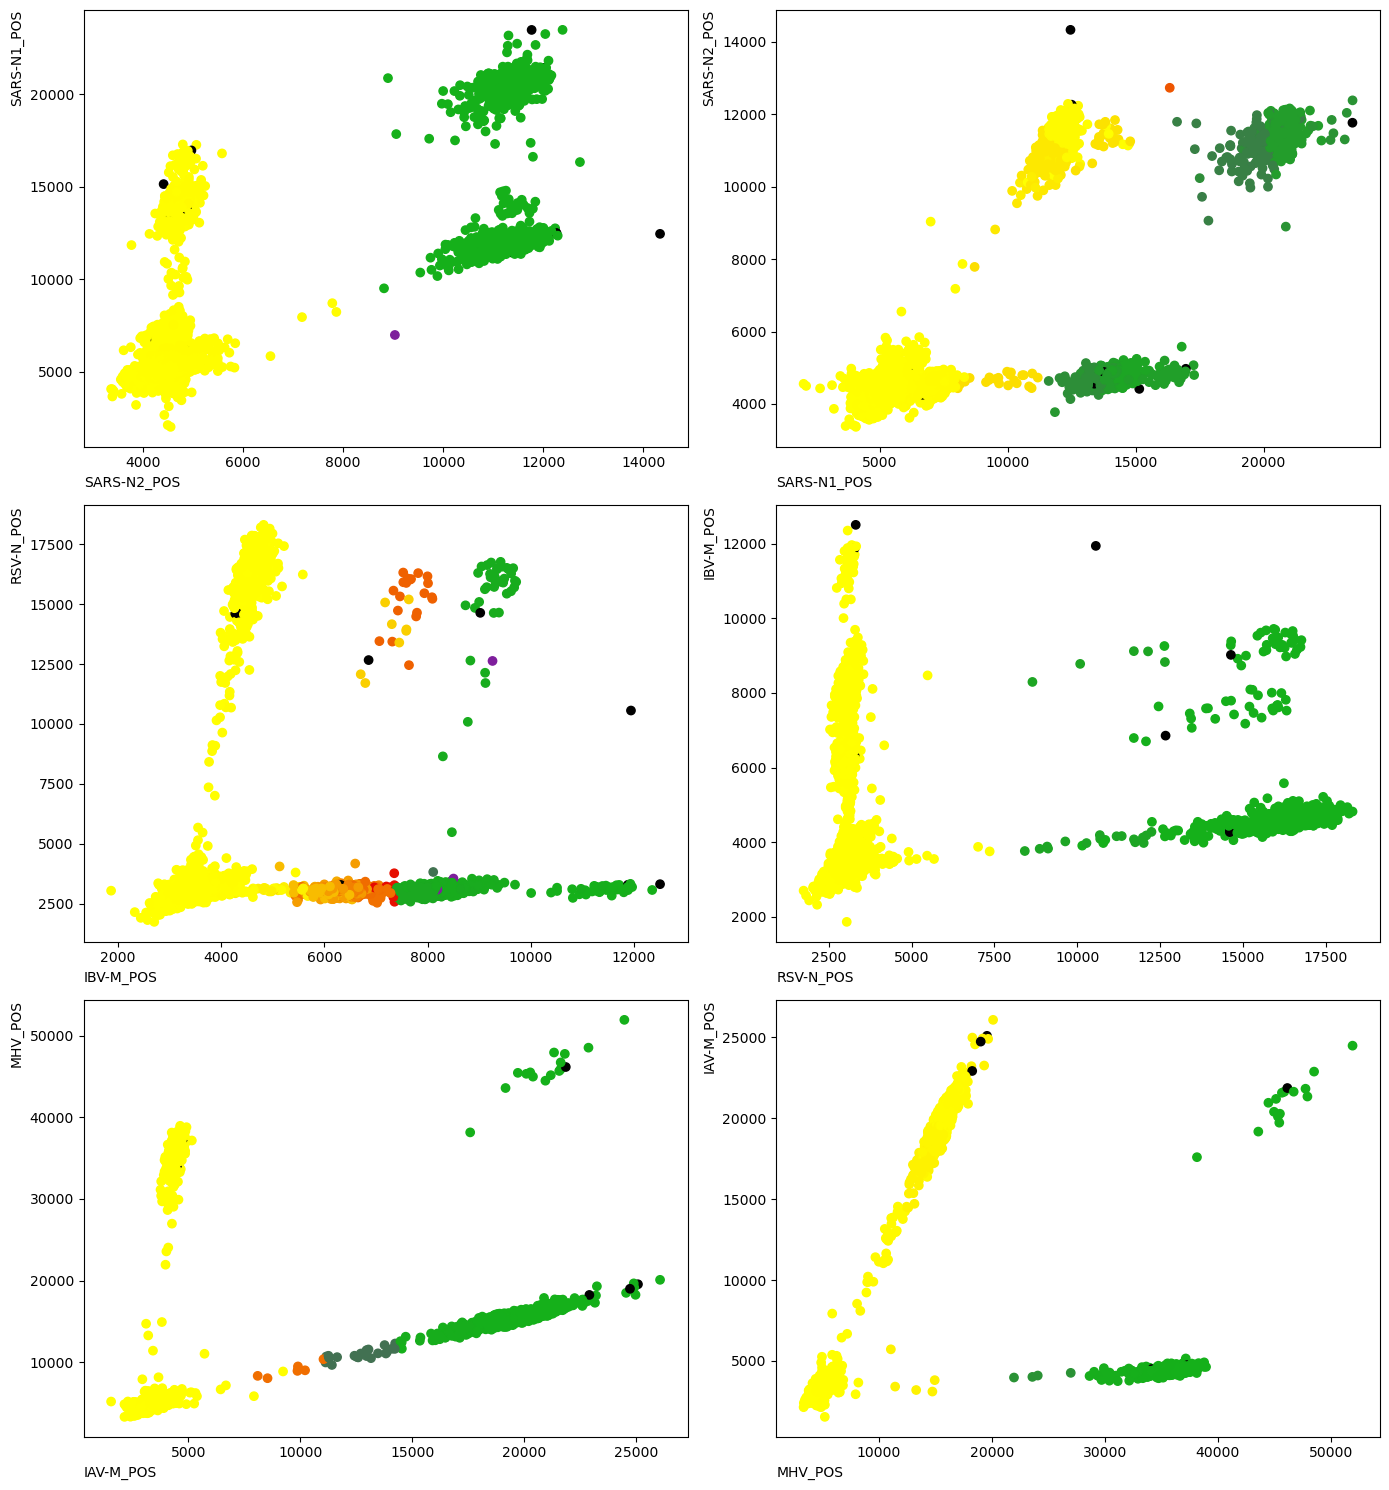

In [29]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_wa
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

validation_lib.validate_labels(df_ground_trouth, df_predictions, threshold=0.5)


plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=decision.No_neg_mask
        )

In [25]:
predicted_percentagees = []
for axis in prediction_axis:
    predicted_percentagees.append((df_predictions > 0.5)[axis].sum() / df_predictions.shape[0])

true_percentages = []
for axis in prediction_axis:
    true_percentages.append(df_wa[axis].sum() / df_predictions.shape[0])

true_log_percentages = [-np.log(1-pct) for pct in true_percentages]
predicted_log_percentages = [-np.log(1-pct) for pct in predicted_percentagees]
print(true_log_percentages)
print(predicted_log_percentages)

[0.009420827191879174, 0.008884826000405186, 0.00429988331359717, 0.003593578889374129, 0.00785292097868831, 0.0058174721203734766]
[0.009367494831614854, 0.008419215270605344, 0.007606318763623317, 0.0035405563980580868, 0.007833302666955543, 0.005797893699708029]


In [26]:
predicted_percentagees

[0.009323756531217762,
 0.008383872932186565,
 0.007577463927100626,
 0.0035342960188421636,
 0.00780270230438325,
 0.0057811183502540185]

In [19]:
true_percentages

[0.009376590224654426,
 0.008845472569580584,
 0.004290652051198629,
 0.0035871297122788285,
 0.0078221673493336,
 0.005800583395204369]